## Importation de librairie

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Fonctions utilitaires générales

In [ ]:
def plot_data(prices, ticker):
    plt.figure(figsize=(10, 5))
    plt.plot(prices.index, prices, label='Stock Prices')
    plt.title(f'Historical Stock Prices for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fetch historical data
def fetch_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1y")  # one year of data by default
    plot_data(data['Close'], ticker)
    return data['Close']

## Fonctions utilitaires pour l'expérience utilisateur

In [ ]:
def calculate_time_to_maturity(maturity_date):
    """Calculate the fraction of the year from today to the maturity date."""
    current_date = datetime.now()
    maturity_date = datetime.strptime(maturity_date, "%d/%m/%Y")
    days_to_maturity = (maturity_date - current_date).days
    years_to_maturity = days_to_maturity / 365.25  # Including leap years
    return max(0, years_to_maturity)  # Ensure non-negative time

def calculate_maturity_date(years_to_maturity):
    """Calculate the maturity date from today given years to maturity."""
    current_date = datetime.now()
    days_to_add = int(years_to_maturity * 365.25)  # Convert years to days, considering leap years
    maturity_date = current_date + timedelta(days=days_to_add)
    return maturity_date.strftime("%d/%m/%Y")  # Return the date as a string in DD/MM/YYYY format

def get_user_input(write_date = False):
    """Get user input for maturity date, strike price, and risk-free rate."""
    print("You can press enter at each input and get the default values")
    ticker_input = input("Enter the ticker corresponding in Yahoo Finance : ") or "ORA.PA"
    if write_date:
        maturity_input = input("Enter the maturity date (DD/MM/YYYY): ")
        # Calculate the time to maturity
        time_to_maturity = calculate_time_to_maturity(maturity_input)
    else:
        time_to_maturity = float(input("Enter the maturity date in year fraction: ") or "1")
        maturity_input = calculate_maturity_date(time_to_maturity)
    strike_input = float(input("Enter the strike price (K): ") or "100")
    risk_free_rate_input = float(input("Enter the risk-free rate (r) as a percentage (default is set for France at a previous date): ") or "3.461") / 100



    print(f"\nTicker: {ticker_input}")
    print(f"Maturity date: {maturity_input}")
    print(f"Time to maturity (in years): {time_to_maturity:.4f}")
    print(f"Strike price: {strike_input}")
    print(f"Risk-free rate: {risk_free_rate_input:.4%}")

    return ticker_input, time_to_maturity, strike_input, risk_free_rate_input

Appels aux fonctions  
Paramètres par défaut:  
ORA.PA  
1  
100  
0.03461 (France 1 year risk free rate taken before)

You can press enter at each input and get the default values
Enter the ticker corresponding in Yahoo Finance : ACA.PA
Enter the maturity date in year fraction: 0.42
Enter the strike price (K): 42
Enter the risk-free rate (r) as a percentage (default is set for France at a previous date): 

Ticker: ACA.PA
Maturity date: 01/11/2024
Time to maturity (in years): 0.4200
Strike price: 42.0
Risk-free rate: 3.4610%


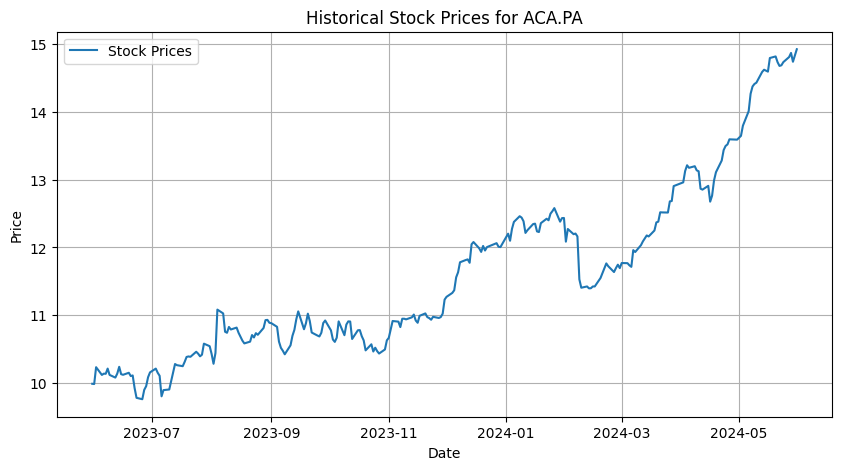




Spot price = 14.925000190734863
Historical volatility = 1.2938144966968332





In [ ]:
ticker, T, K, r = get_user_input()

prices = fetch_data(ticker)


print("\n\n")
S = prices.iloc[-1]
print(f"Spot price = {S}")

sigma = np.std(prices)
print(f"Historical volatility = {sigma}")
print("\n\n")

## Fonctions de Black & Scholes

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price for a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    call_price = S * N_d1 - K * np.exp(-r * T) * N_d2

    print(f"d1 = {d1}")
    print(f"d2 = {d2}")
    print(f"N_d1 = {N_d1}")
    print(f"N_d2 = {N_d2}")
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    """Calculate the Black-Scholes price for a European put option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N_minus_d1 = norm.cdf(-d1)
    N_minus_d2 = norm.cdf(-d2)
    put_price = K * np.exp(-r * T) * N_minus_d2 - S * N_minus_d1

    print(f"d1 = {d1}")
    print(f"d2 = {d2}")
    print(f"N_minus_d1 = {N_minus_d1}")
    print(f"N_minus_d2 = {N_minus_d2}")
    return put_price

Appels aux fonctions de Black & Scholes, utilisation des paramètres rentrés par l'utilisateur.

In [ ]:
call_price = black_scholes_call(S, K, T, r, sigma)
put_price = black_scholes_put(S, K, T, r, sigma)

print("B&S European Call Option Price: ", call_price)
print("B&S European Put Option Price: ", put_price)

d1 = -0.7973462877800318
d2 = -1.6358339142733567
N_d1 = 0.21262497229604066
N_d2 = 0.05093717601468157
d1 = -0.7973462877800318
d2 = -1.6358339142733567
N_minus_d1 = 0.7873750277039593
N_minus_d2 = 0.9490628239853184
B&S European Call Option Price:  1.0649396110249598
B&S European Put Option Price:  27.533834920910593


______________________________________________________________________________________________________________________
# Modèle de Heston

## Récupération des différents paramètres utilisé par le modèle de Heston

### Paramètres qui peuvent être récupéré ou calculé simplement

In [ ]:

# S0
def get_initial_stock_price(prices):
    # daily
    return prices.iloc[-1]  # Latest closing price

# V0
def get_initial_variance(prices):
    daily_returns = prices.pct_change().dropna()
    variance = daily_returns.var()
    return variance

# r / mu - risk free rate - can be statically obtained or via an API

# target theta
def estimate_theta(historical_variances):
    return np.mean(historical_variances)  # simple mean for the moment

# rho - correlation between stock and variance
def estimate_rho(historical_prices, historical_variances, W):
    return np.corrcoef(historical_prices[W-1:].pct_change().dropna(), np.sqrt(historical_variances))[0, 1]

print("\nN.B. Nb of days is hardcoded and set to N=255 (function=determine_time_steps)\n")
# N
def determine_time_steps(T, step_size='daily'):
    if step_size == 'daily':
        return int(T * 255)  # Daily steps
    elif step_size == 'monthly':
        return int(T * 12)  # Monthly steps

# M Number of Simulation Paths

def calculate_historical_variances(prices, W):
    """Calculate daily variances from historical price data."""
    returns = prices.pct_change().dropna()  # daily returns
    daily_variances = returns.rolling(window=W).var()  # 30-day rolling variance
    clean_data = daily_variances[~np.isnan(daily_variances)]
    return clean_data


N.B. Nb of days is hardcoded and set to N=255 (function=determine_time_steps)



### Paramètres necéssitant une calibration, par méthode troncature complète

In [ ]:
# kappa - Rate of Reversion - Calibration
# simga - Variance - Calibration

def simulate_variances(v0, kappa, theta, sigma, T, N):
    """
    Simulate variance paths using the Euler-Maruyama method for the Heston model.

    Parameters:
    v0 : float
        Initial variance.
    kappa : float
        Rate of mean reversion.
    theta : float
        Long-term mean variance.
    sigma : float
        Volatility of the variance process.
    T : float
        Total time to maturity or simulation length in years.
    N : int
        Number of steps in the simulation.

    Returns:
    np.ndarray
        Simulated variance path.
    """
    dt = T / N  # Time step

    # Initialize the variance path array
    variances = np.zeros(N + 1)
    variances[0] = v0

    # Generate random increments
    dW = np.random.normal(0, 1, N) * np.sqrt(dt)

    # Simulate the variance path
    for t in range(1, N + 1):
        # Apply the full truncation scheme to ensure non-negativity
        current_variance = max(variances[t - 1], 0)
        # Euler-Maruyama update for the variance
        variances[t] = current_variance + kappa * (theta - current_variance) * dt + sigma * np.sqrt(current_variance) * \
                       dW[t - 1]
        # Enforce non-negative variance
        variances[t] = max(variances[t], 0)

    return variances


def objective_function(params, historical_variances, v0, theta, T, N):
    kappa, sigma = params
    L = len(historical_variances)
    simulated_variances = simulate_variances(v0, kappa, theta, sigma, T, N)
    M = len(simulated_variances)

    # Trim the simulated variances to match the length of historical variances
    if len(historical_variances) < len(simulated_variances):
        simulated_variances = simulated_variances[-L:]
    if len(historical_variances) > len(simulated_variances):
        historical_variances = historical_variances[-M:]

    # Calculate the sum of squared differences between historical and simulated variances
    return np.sum((historical_variances - simulated_variances) ** 2)

def calibrate_parameters(historical_variances, v0, theta, T, N):
    initial_guess = [0.5, 0.2]  # Initial guesses for kappa and sigma

    # Bounds obtained from The Heston Model and its Extensions in Matlab and C#", by Rouah (2013)
    bounds = [(0.01, 5.0), (0.01, 1.0)]  # Set reasonable bounds for kappa and sigma
    result = minimize(objective_function, initial_guess, args=(historical_variances, v0, theta, T, N), bounds=bounds)
    return result.x  # Returns the optimized kappa and sigma

### Récupération de tous les paramètres de Heston

In [ ]:
def heston_parameters(ticker, K, T, step_size='daily', M=1000, r=0.03461, W=30):
    """
    Gather all necessary parameters for the Heston model and price an option.

    Parameters:
    - ticker: str, the stock ticker to fetch historical data for.
    - K: float, strike price of the option.
    - T: float, time to maturity in years.
    - step_size: str, 'daily' or 'monthly' steps for simulation.
    - M: int, number of paths for Monte Carlo simulation.
    - r: float, static risk-free rate - check Central Bank
    - W: int, rolling-window for historical variances

    Returns:
    - float, the estimated price of the European call option.
    """
    # Fetch data
    prices = fetch_data(ticker)
    historical_variances = calculate_historical_variances(prices, W)

    # Get initial stock price and variance
    S0 = get_initial_stock_price(prices)
    v0 = get_initial_variance(prices)
    theta = estimate_theta(historical_variances)

    # Calibrate kappa and sigma
    N = determine_time_steps(T, step_size)
    calibrated_params = calibrate_parameters(historical_variances, v0, theta, T, N)
    kappa, sigma = calibrated_params

    # Assume a typical value for rho
    rho = estimate_rho(prices, historical_variances, W)

    print(f"S0 = {S0}")
    print(f"v0 = {v0}")
    print(f"K = {K}")
    print(f"r = {r}")
    print(f"kappa = {kappa}")
    print(f"theta = {theta}")
    print(f"sigma = {sigma}")
    print(f"rho = {rho}")
    print(f"T = {T}")
    print(f"dt = {T/N}")
    print(f"N = {N}")

    # Return parameters
    return S0, v0, K, r, kappa, theta, sigma, rho, T, T/N, M

On réutilise ici les paramètres données pour le modèle de Black & Scholes afin que l'utilisateur puisse comparer le résultat des deux modèles.

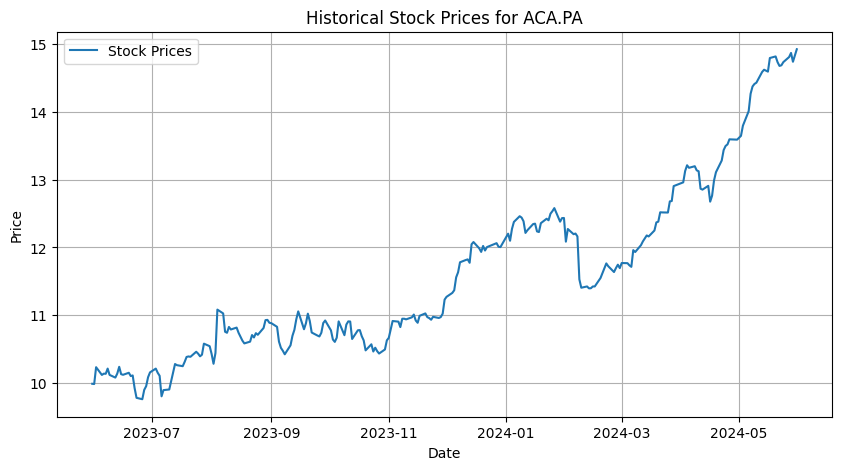

S0 = 14.925000190734863
v0 = 0.00010715077900767049
K = 42.0
r = 0.03461
kappa = 0.5000097072478855
theta = 0.00011084188829900496
sigma = 0.1999995886248406
rho = -0.10562413363228952
T = 0.42
dt = 0.003925233644859813
N = 107


In [ ]:
# Example usage
params = heston_parameters(ticker, K, T)

## Generation des chemins simulés par  Monte-Carlo

In [ ]:
def heston_model_full_truncation(S0, v0, mu, kappa, theta, sigma, rho, T, N, M):
    """
    Generate Monte Carlo simulation paths for the Heston model using the full truncation method.

    Parameters:
    - S0: Initial stock price
    - v0: Initial variance
    - mu: Drift rate of the asset
    - kappa: Rate of reversion
    - theta: Long-term variance
    - sigma: Volatility of variance
    - rho: Correlation between stock and variance paths
    - T: Time to maturity
    - N: Number of time steps
    - M: Number of paths

    Returns:
    - S: Simulated paths of stock price
    - v: Simulated paths of variance
    """
    dt = T / N
    S = np.zeros((M, N+1))
    v = np.zeros((M, N+1))
    S[:, 0] = S0
    v[:, 0] = v0

    # Generate correlated random numbers
    Z1 = np.random.normal(size=(M, N))
    Z2 = np.random.normal(size=(M, N))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # Correlated random numbers

    for t in range(1, N+1):
        # Full truncation for the variance process
        v_prev = np.maximum(v[:, t-1], 0)
        v[:, t] = v_prev + kappa * (theta - v_prev) * dt + sigma * np.sqrt(v_prev) * np.sqrt(dt) * Z2[:, t-1]
        v[:, t] = np.maximum(v[:, t], 0)  # Ensure non-negative variance

        # Stock price process
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * Z1[:, t-1])

    return S, v

## Algorithme du modèle de Heston

In [ ]:
def heston_option_pricing(S0, v0, K, r, kappa, theta, sigma, rho, T, dt, M, option_type='call'):
    """
    Calculate the price of a European option (call or put) using the Heston model.

    Parameters:
    - S0: Initial stock price
    - v0: Initial variance
    - K: Strike price
    - r: Risk-free interest rate
    - kappa: Rate of reversion
    - theta: Long-term variance
    - sigma: Volatility of variance
    - rho: Correlation between stock and variance paths
    - T: Time to maturity
    - dt: Time step
    - M: Number of paths
    - option_type: Type of the option ('call' or 'put')

    Returns:
    - float: Estimated price of the option
    """
    N = int(T / dt)
    S, v = heston_model_full_truncation(S0, v0, r, kappa, theta, sigma, rho, T, N, M)

    # Determine the payoff based on option type
    if option_type.lower() == 'call':
        payoffs = np.maximum(S[:, -1] - K, 0)
    elif option_type.lower() == 'put':
        payoffs = np.maximum(K - S[:, -1], 0)
    else:
        raise ValueError("Invalid option type specified. Use 'call' or 'put'.")

    # Discount payoffs to present value
    discounted_payoff = np.exp(-r * T) * payoffs

    # Calculate the option price as the average of discounted payoffs
    option_price = np.mean(discounted_payoff)

    return option_price

### calculs

In [ ]:
# Calculate the option price
option_price_call = heston_option_pricing(*params)
option_price_put = heston_option_pricing(*params, 'put')
print("Heston model - European call option:", option_price_call)
print("Heston model - European put option:", option_price_put)

Heston model - European call option: 0.0
Heston model - European put option: 26.469558301453187
